This is a figure for the model description section which will provide validation of ABSW/CDW temperature and salinity compared to the Schmidkto 2014 data and possibly also include SWMT/age map (might include this in a results figure covering SWMT/DSW responses? Make an option either way.)

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import matplotlib.colors as col
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath
import matplotlib.patches as mpatches
from matplotlib.transforms import offset_copy
import matplotlib.path as mpath
import sys
sys.path.append('/home/156/rm2389/Honours_Thesis/python_functions/')
from masking import shelf_mask_isobath, fill_land
import cosima_cookbook as cc
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from spatial_averaging import month_weights
from matplotlib import rc, rcParams
rc('text', usetex=True)
import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
from dask.distributed import Client
client = Client('tcp://localhost:8786')
client

netcdf_index loaded.


<Client: scheduler='tcp://10.0.64.25:8786' processes=6 cores=6>

In [2]:
import cmocean.cm as cmo
from gsw import SA_from_SP, p_from_z, CT_from_pt, sigma1
rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
rc('xtick', labelsize=40) 
rc('ytick', labelsize=40) 
rc('axes', labelsize=40) 

In [3]:
## land masks and isobath masks
ht = cc.get_nc_variable('/g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf8485_freshRCP45','ocean_grid.nc','ht', n=1)
ht = ht.sel(yt_ocean = slice(-90,-55))
land_mask = np.squeeze(ht.values)
land_mask = land_mask * 0
land_mask[np.isnan(land_mask)] = 1
yt_ocean =ht.yt_ocean.values
xt_ocean =ht.xt_ocean.values
ht_shelf , shelf_mask = shelf_mask_isobath(ht)

Using database sqlite:////g/data3/hh5/tmp/cosima/access-om2-01/01deg_jra55v13_ryf8485_freshRCP45/cosima-cookbook.db


In [10]:
## observed 
CDW_Observed = xr.open_dataset('/g/data/v45/rm2389/Schmidtko_Observations/CDW_Temp_Salt_new.nc')
WW_Observed = xr.open_dataset('/g/data/v45/rm2389/Schmidtko_Observations/WW_Temp_Salt_new.nc')
AASW_Observed = xr.open_dataset('/g/data/v45/rm2389/Schmidtko_Observations/AASW_Temp_Salt.nc')
CDW_CT = CDW_Observed.CT
CDW_AS = CDW_Observed.AS
WW_CT = WW_Observed.CT
WW_AS = WW_Observed.AS
AASW_CT = AASW_Observed.CT
AASW_AS = AASW_Observed.AS
CDW_CT_masked = CDW_CT.sel(lat = slice(-80,-55))
CDW_AS_masked = CDW_AS.sel(lat = slice(-80,-55))
WW_CT_masked = WW_CT.sel(lat = slice(-80,-55))
WW_AS_masked = WW_AS.sel(lat = slice(-80,-55))

In [11]:
bottom_con_temp_control = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/bottom_CT_control.nc', chunks= {'time':None, 'yt_ocean':300, 'xt_ocean':400})
bottom_abs_salt_control = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/bottom_AS_control.nc', chunks= {'time':None, 'yt_ocean':300, 'xt_ocean':400})
bottom_con_temp_control = bottom_con_temp_control.bottom_temp
bottom_abs_salt_control = bottom_abs_salt_control.bottom_salt
time = bottom_con_temp_control.time.values
weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=1), coords = [time], dims = 'time')
weights = weights.chunk({'time':1})
bottom_con_temp_control = (bottom_con_temp_control * weights).mean(dim = 'time')
bottom_abs_salt_control = (bottom_abs_salt_control * weights).mean(dim = 'time')
bottom_con_temp_control = bottom_con_temp_control.load()
bottom_abs_salt_control = bottom_abs_salt_control.load()

In [12]:
CDW_temp = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/CDW_CT_control_timeseries_1942-06-1947-05.nc', chunks = {'time':None, 'yt_ocean':500, 'xt_ocean':500})
CDW_temp = CDW_temp.CDW_temp
# time = CDW_temp.time.values
# weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=5), coords = [time], dims = 'time')
# weights = weights.chunk({'time':1})
CDW_temp_mean = (CDW_temp).mean(dim = 'time')

In [13]:
CDW_salt = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/CDW_AS_control_timeseries_1942-06-1947-05.nc', chunks = {'time':None, 'yt_ocean':500, 'xt_ocean':500})
CDW_salt = CDW_salt.CDW_salt
# time = CDW_salt.time.values
# weights = xr.DataArray(month_weights(start_month=6, end_month=5, n_years=1), coords = [time], dims = 'time')
# weights = weights.chunk({'time':1})
CDW_salt = CDW_salt.where(CDW_salt>0)
CDW_salt_mean = (CDW_salt).mean(dim = 'time') # for some reason the weighted mean was wacky

In [14]:
## create a mask that masks OUT the shelf (opposite of function shelf_mask_isobath)
yt_ocean_full = CDW_salt_mean.yt_ocean
yt_ocean_add = yt_ocean_full.sel(yt_ocean = slice(-59, None))
extra_rows = np.zeros((74,3600))
shelf_mask_extended = np.append(shelf_mask.values, extra_rows, axis = 0)
shelf_mask_ext  = xr.DataArray(shelf_mask_extended,coords = [('yt_ocean', yt_ocean_full), ('xt_ocean', xt_ocean)] )
shelf_mask_ext = shelf_mask_ext.where(shelf_mask_ext == 0) + 1
CDW_salt_mean = CDW_salt_mean * shelf_mask_ext
CDW_salt_mean=CDW_salt_mean.load()
CDW_temp_mean = CDW_temp_mean * shelf_mask_ext
CDW_temp_mean = CDW_temp_mean.load()

In [4]:
import matplotlib.ticker as mticker

In [5]:
def antarctic_map(ax, isobath_linewidth, grid, north, isobath_colour = 'k'):
    ax.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform=ccrs.PlateCarree())
    ax.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = isobath_colour, linewidth = isobath_linewidth, transform=ccrs.PlateCarree())
    ax.set_boundary(circle, transform=ax.transAxes)
    ax.set_extent([-180, 180, -90, north], ccrs.PlateCarree())
    if grid == True:
        gl = ax.gridlines(linewidth = 1, color = 'grey', linestyle = '--')
        gl.ylocator = mticker.FixedLocator([-90,-80,-70, -60, -50])

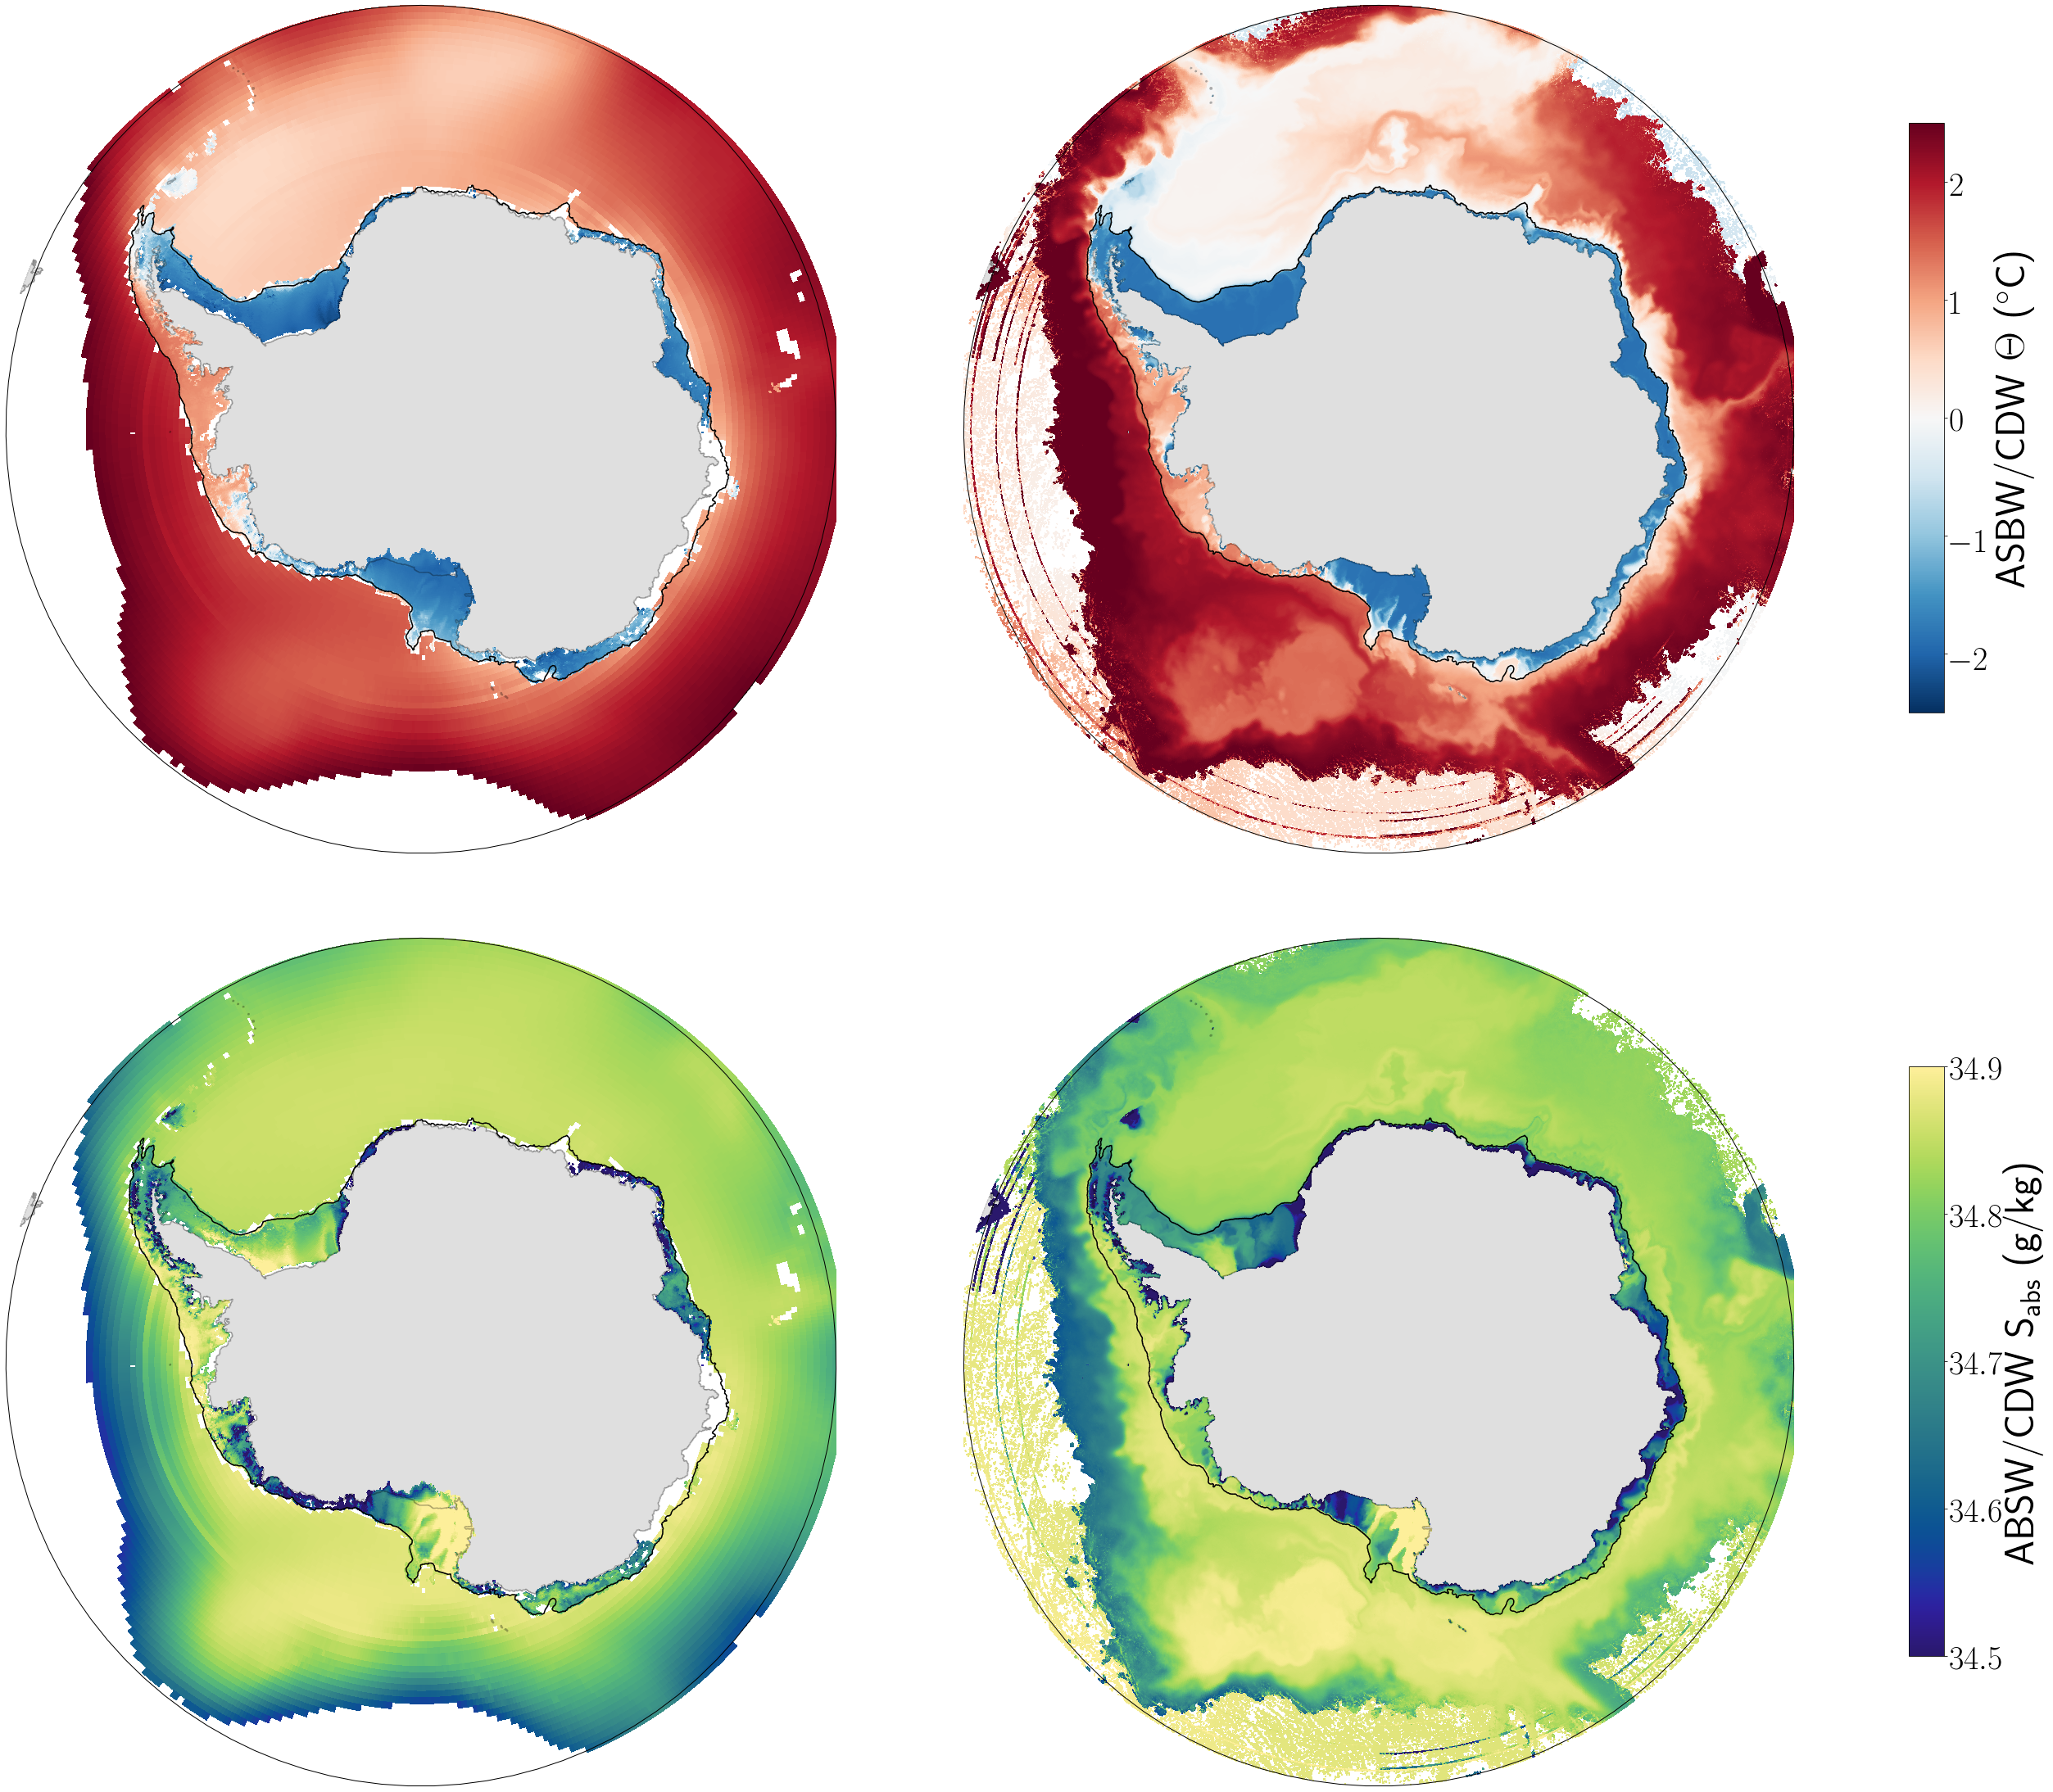

In [47]:
fig, ax  = plt.subplots(2,2, figsize = (40,40))
gs = gridspec.GridSpec(2,2)
ax0, ax1, ax2, ax3 = plt.subplot(gs[0,0],projection=ccrs.SouthPolarStereo()), plt.subplot(gs[0,1],projection=ccrs.SouthPolarStereo()),plt.subplot(gs[1,0],projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1,1],projection=ccrs.SouthPolarStereo())
gs.update(hspace = 0.1, wspace = 0.1)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

## fill continent (silver)
fill_land(land_mask, ax0, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
fill_land(land_mask, ax1, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
fill_land(land_mask, ax2, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
fill_land(land_mask, ax3, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
    
## CDW
norm = col.Normalize(vmin=-2.5,vmax=2.5)
ax0.pcolormesh(CDW_CT_masked.lon, CDW_CT_masked.lat, CDW_CT_masked,cmap='RdBu_r',norm=norm,transform=ccrs.PlateCarree())
ax0.pcolormesh(AASW_CT.lon, AASW_CT.lat, AASW_CT,cmap='RdBu_r',norm=norm,transform=ccrs.PlateCarree())
CDW_temp = ax1.pcolormesh(CDW_temp_mean.xt_ocean,CDW_temp_mean.yt_ocean,CDW_temp_mean.values,cmap='RdBu_r',norm=norm,transform=ccrs.PlateCarree())
ASBW_temp = ax1.pcolormesh(bottom_con_temp_control.xt_ocean,bottom_con_temp_control.yt_ocean,bottom_con_temp_control.values,cmap='RdBu_r',norm=norm,transform=ccrs.PlateCarree())
# mapping 
antarctic_map(ax0, isobath_linewidth = 6, grid = False, north = -55)
antarctic_map(ax1, isobath_linewidth = 6, grid = False, north = -55)

## CDW
norm = col.Normalize(vmin=34.5,vmax=34.9)
control_salt = ax2.pcolormesh(CDW_AS_masked.lon, CDW_AS_masked.lat, CDW_AS_masked,cmap=cmo.haline,norm = norm, transform=ccrs.PlateCarree())
ax2.pcolormesh(AASW_AS.lon, AASW_AS.lat, AASW_AS,cmap=cmo.haline,norm=norm,transform=ccrs.PlateCarree())
ax3.pcolormesh(CDW_salt_mean.xt_ocean,CDW_salt_mean.yt_ocean,CDW_salt_mean.values, cmap=cmo.haline,norm=norm,transform=ccrs.PlateCarree())
ax3.pcolormesh(bottom_abs_salt_control.xt_ocean,bottom_abs_salt_control.yt_ocean,bottom_abs_salt_control.values, cmap=cmo.haline,norm=norm,transform=ccrs.PlateCarree())
## mapping
antarctic_map(ax2, isobath_linewidth = 6, grid = False, north = -55)
antarctic_map(ax3, isobath_linewidth = 6, grid = False, north = -55)

## temperature colorbar
cax = fig.add_axes([0.94, 0.58, 0.015, 0.25])
cbar=plt.colorbar(CDW_temp,cax = cax,orientation='vertical',shrink = 0.5, ticks = [ -2,-1, 0, 1.0,2.0])
cbar.set_label(r'ASBW/CDW $\Theta$ ($^\circ$C)', fontsize = 50)
# ## salinity colorbar
cax = fig.add_axes([0.94, 0.18, 0.015, 0.25])
cbar=plt.colorbar(control_salt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [34.5, 34.6, 34.7,34.8,34.9])
cbar.set_label(r'ABSW/CDW S$_\text{abs}$ (g/kg)', fontsize = 50)

figurepath = 'Figure_1_Temp_Salt_Validation.png'
fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='png',
            transparent=False, bbox_inches='tight', pad_inches=0.1,
            frameon=None)

plt.show()   

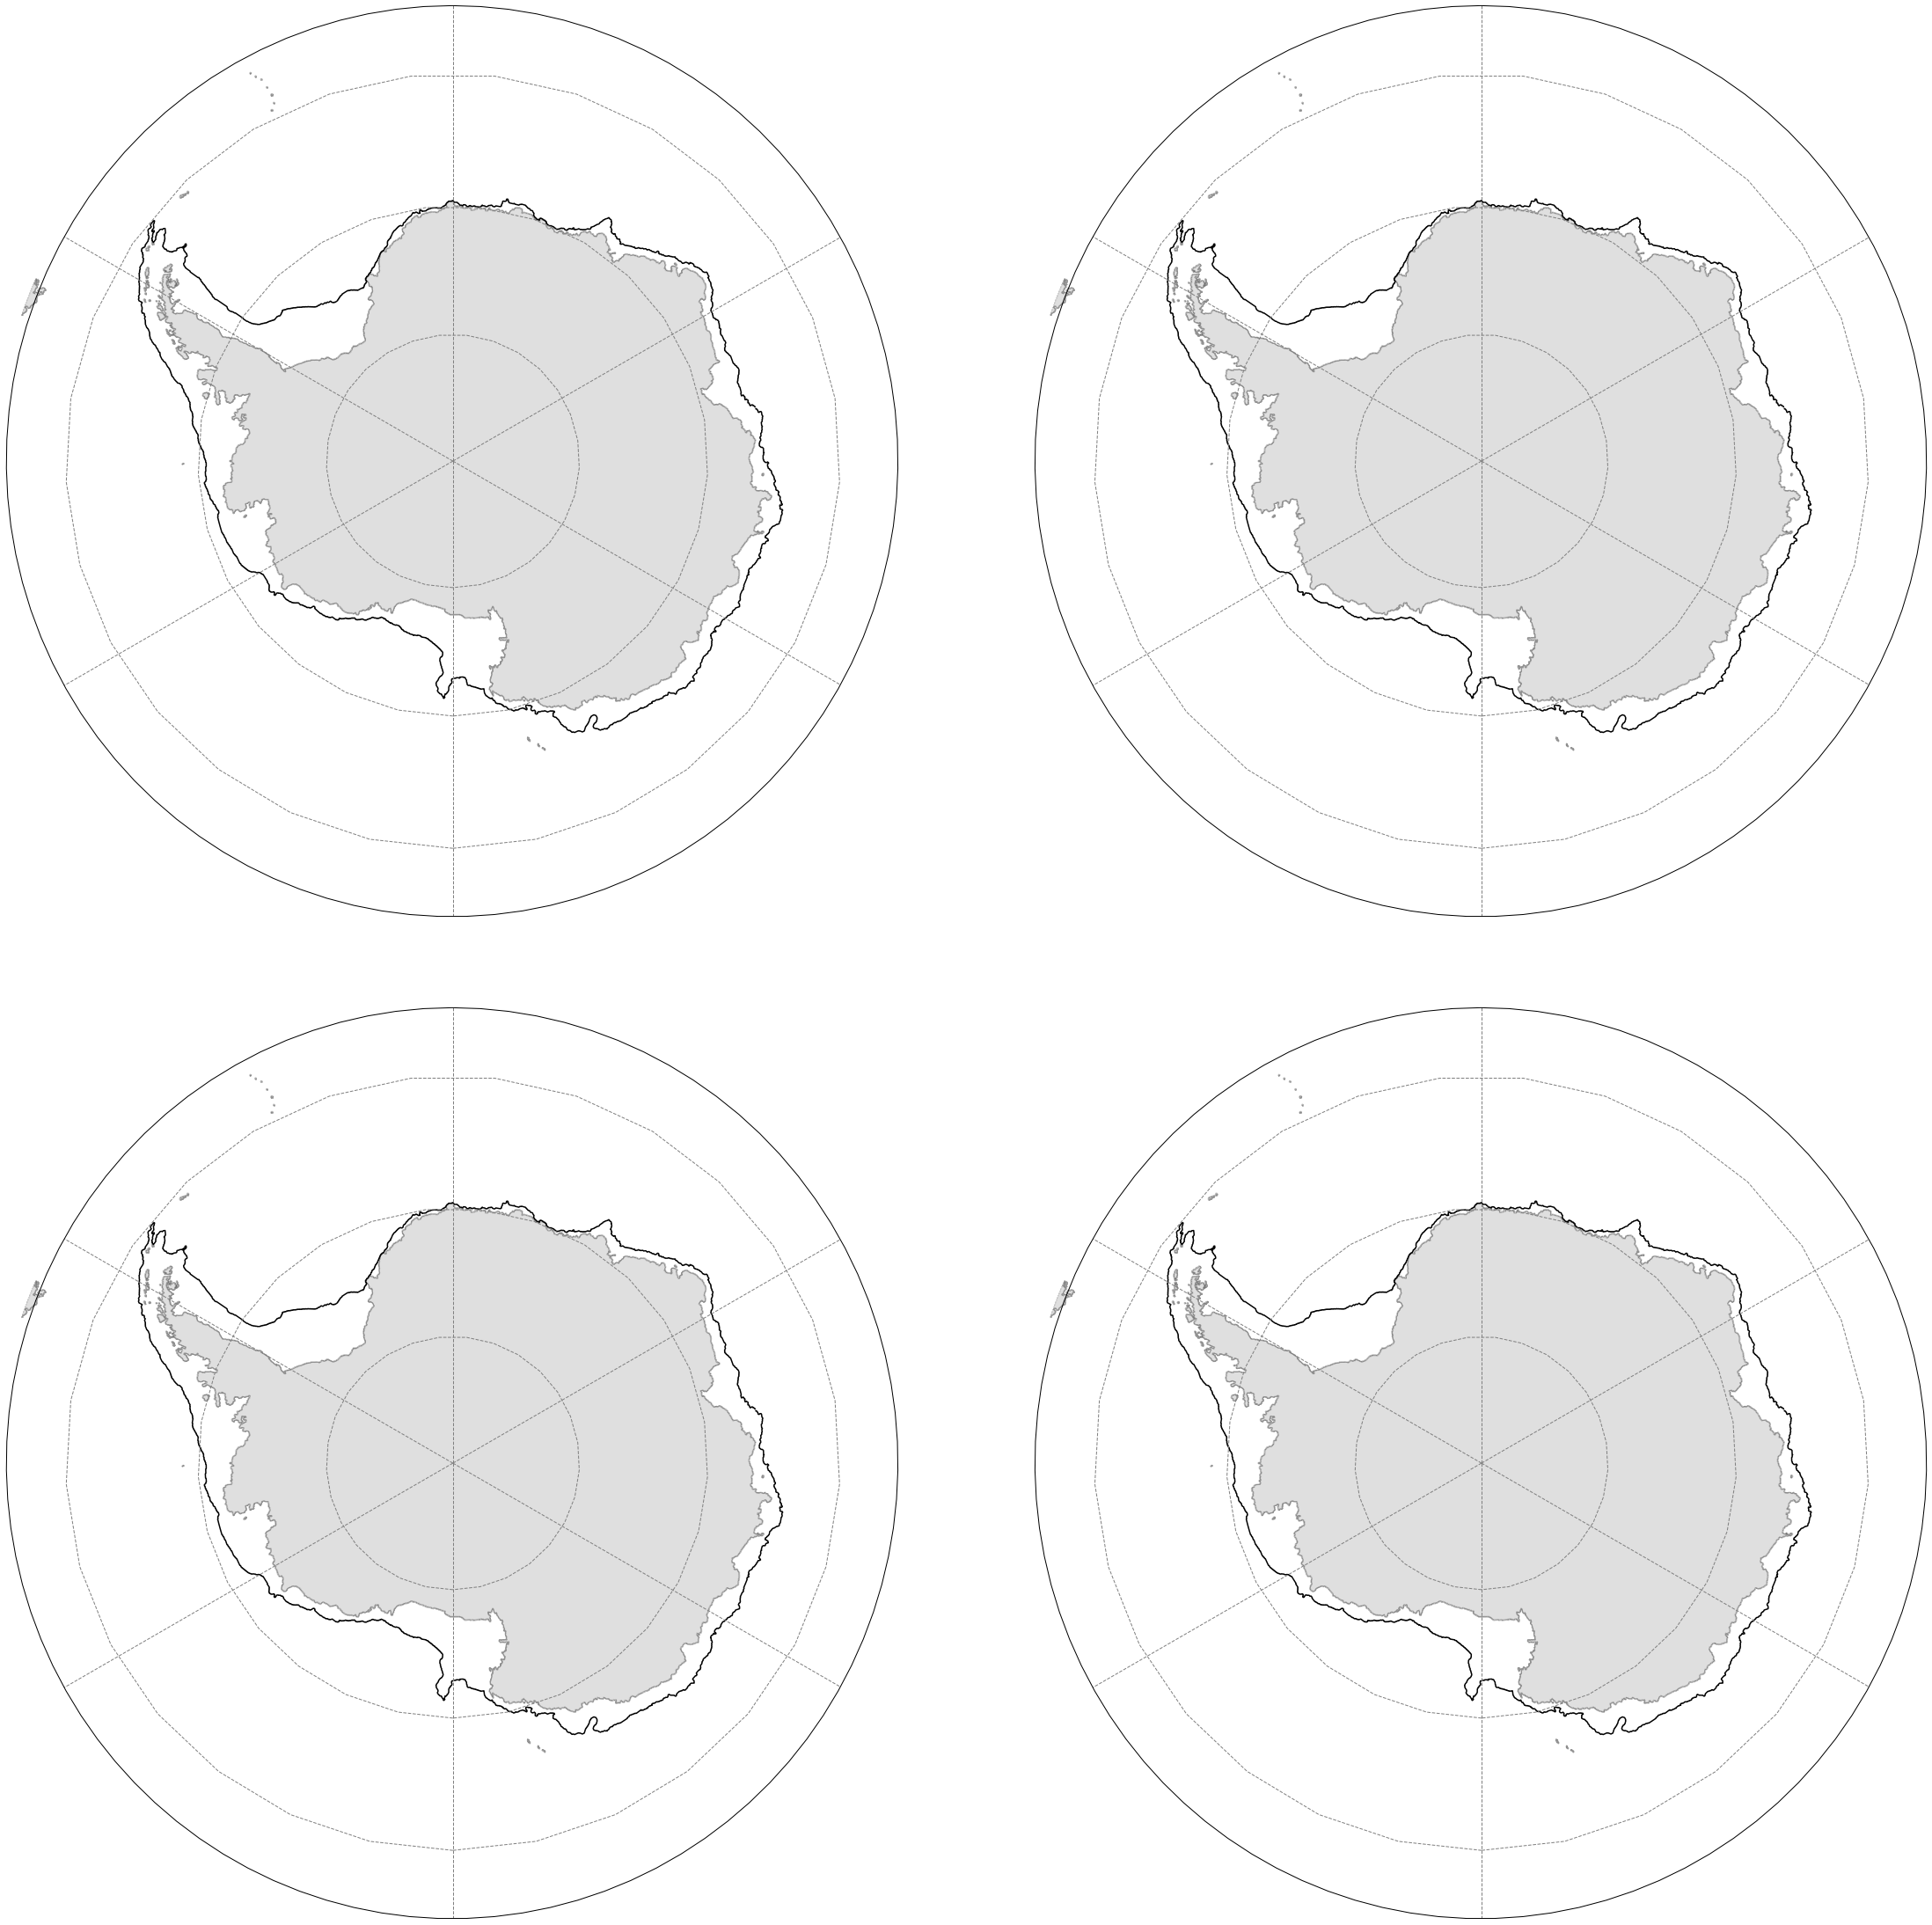

In [6]:
fig, ax  = plt.subplots(2,2, figsize = (40,40))
gs = gridspec.GridSpec(2,2)
ax0, ax1, ax2, ax3 = plt.subplot(gs[0,0],projection=ccrs.SouthPolarStereo()), plt.subplot(gs[0,1],projection=ccrs.SouthPolarStereo()),plt.subplot(gs[1,0],projection=ccrs.SouthPolarStereo()), plt.subplot(gs[1,1],projection=ccrs.SouthPolarStereo())
gs.update(hspace = 0.1, wspace = 0.1)
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

## fill continent (silver)
fill_land(land_mask, ax0, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
fill_land(land_mask, ax1, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
fill_land(land_mask, ax2, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
fill_land(land_mask, ax3, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
    
antarctic_map(ax0, isobath_linewidth = 6, grid = True, north = -55)
antarctic_map(ax1, isobath_linewidth = 6, grid = True, north = -55)
antarctic_map(ax2, isobath_linewidth = 6, grid = True, north = -55)
antarctic_map(ax3, isobath_linewidth = 6, grid = True, north = -55)


figurepath = 'Figures/Tools/gridding.png'
fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='png',
            transparent=False, bbox_inches='tight', pad_inches=0.1,
            frameon=None)

plt.show()   

So now we have an option with just the temperature an salinity information. Might want an option which also includes a map of swmt into downwelling density classes and age difference (or just bottom age?).

In [7]:
def get_SWMT(dirpath, time_bounds):
    net_transformation = xr.open_dataset(dirpath+'SWMT_'+time_bounds+'.nc',chunks={'isopycnal_bins':1})
    net_transformation = net_transformation.surface_water_mass_transformation
    heat_transformation = xr.open_dataset(dirpath+'HT_'+time_bounds+'.nc',chunks={'isopycnal_bins':1})
    heat_transformation = heat_transformation.binned_heat_transformation
    salt_transformation = xr.open_dataset(dirpath+'ST_'+time_bounds+'.nc',chunks={'isopycnal_bins':1})
    salt_transformation = salt_transformation.binned_salt_transformation
    return  net_transformation, heat_transformation, salt_transformation

In [8]:
net_transformation = get_SWMT('/g/data/v45/rm2389/SWMT/01deg_jra55v13_ryf8485_spinup6/', '1937_6-1940_5')[0]
area_t = cc.get_nc_variable('01deg_jra55v13_ryf8485_spinup6','ocean_grid.nc', 'area_t', n = 1)
area_t = area_t.sel(yt_ocean = slice(-90, -59))
area_t = area_t.load()
net_transformation, shelf_mask = shelf_mask_isobath(net_transformation)
net_sum = (net_transformation* area_t/1e6).sum(dim = 'xt_ocean').sum(dim= 'yt_ocean').values
max_transformation_index = np.argmin(net_sum) 
isopycnal_bin_mid = net_transformation.isopycnal_bins.values
max_transformation_density = isopycnal_bin_mid[max_transformation_index]
net_plot = net_transformation.isel(isopycnal_bins = max_transformation_index)*1e5*-1
swmt_xt = net_plot.xt_ocean
swmt_yt = net_plot.yt_ocean
net_plot = net_plot.where(net_plot>0).values

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


In [9]:
age = xr.open_dataset('/g/data/v45/rm2389/Water_Mass_Tracers/control_mean_age.nc', chunks = {'st_ocean':None, 'xt_ocean':300, 'yt_ocean':300})
age = age.age
dummy = age * 0 + 1
depth_array = dummy * 0 + dummy.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)
bottom_mask = depth_array.where(depth_array.st_ocean >= max_depth) * 0 + 1
bottom_age = age * bottom_mask
bottom_age = bottom_age.sum(dim = 'st_ocean')
bottom_age = bottom_age.load()

In [15]:
max_age = bottom_age.max().values
age_norm = bottom_age/max_age
age_norm = age_norm.sel(yt_ocean = slice(-90,-55))
age_norm_off = age_norm * shelf_mask_ext
age_norm_off = age_norm_off.load()


In [29]:
contour_4000m = ht.sel(yt_ocean = slice(-90,-59))
contour_4000m = contour_4000m.where(contour_4000m > 4000)
contour_4000m = contour_4000m * 0 + 1
contour_4000m = contour_4000m.fillna(0)

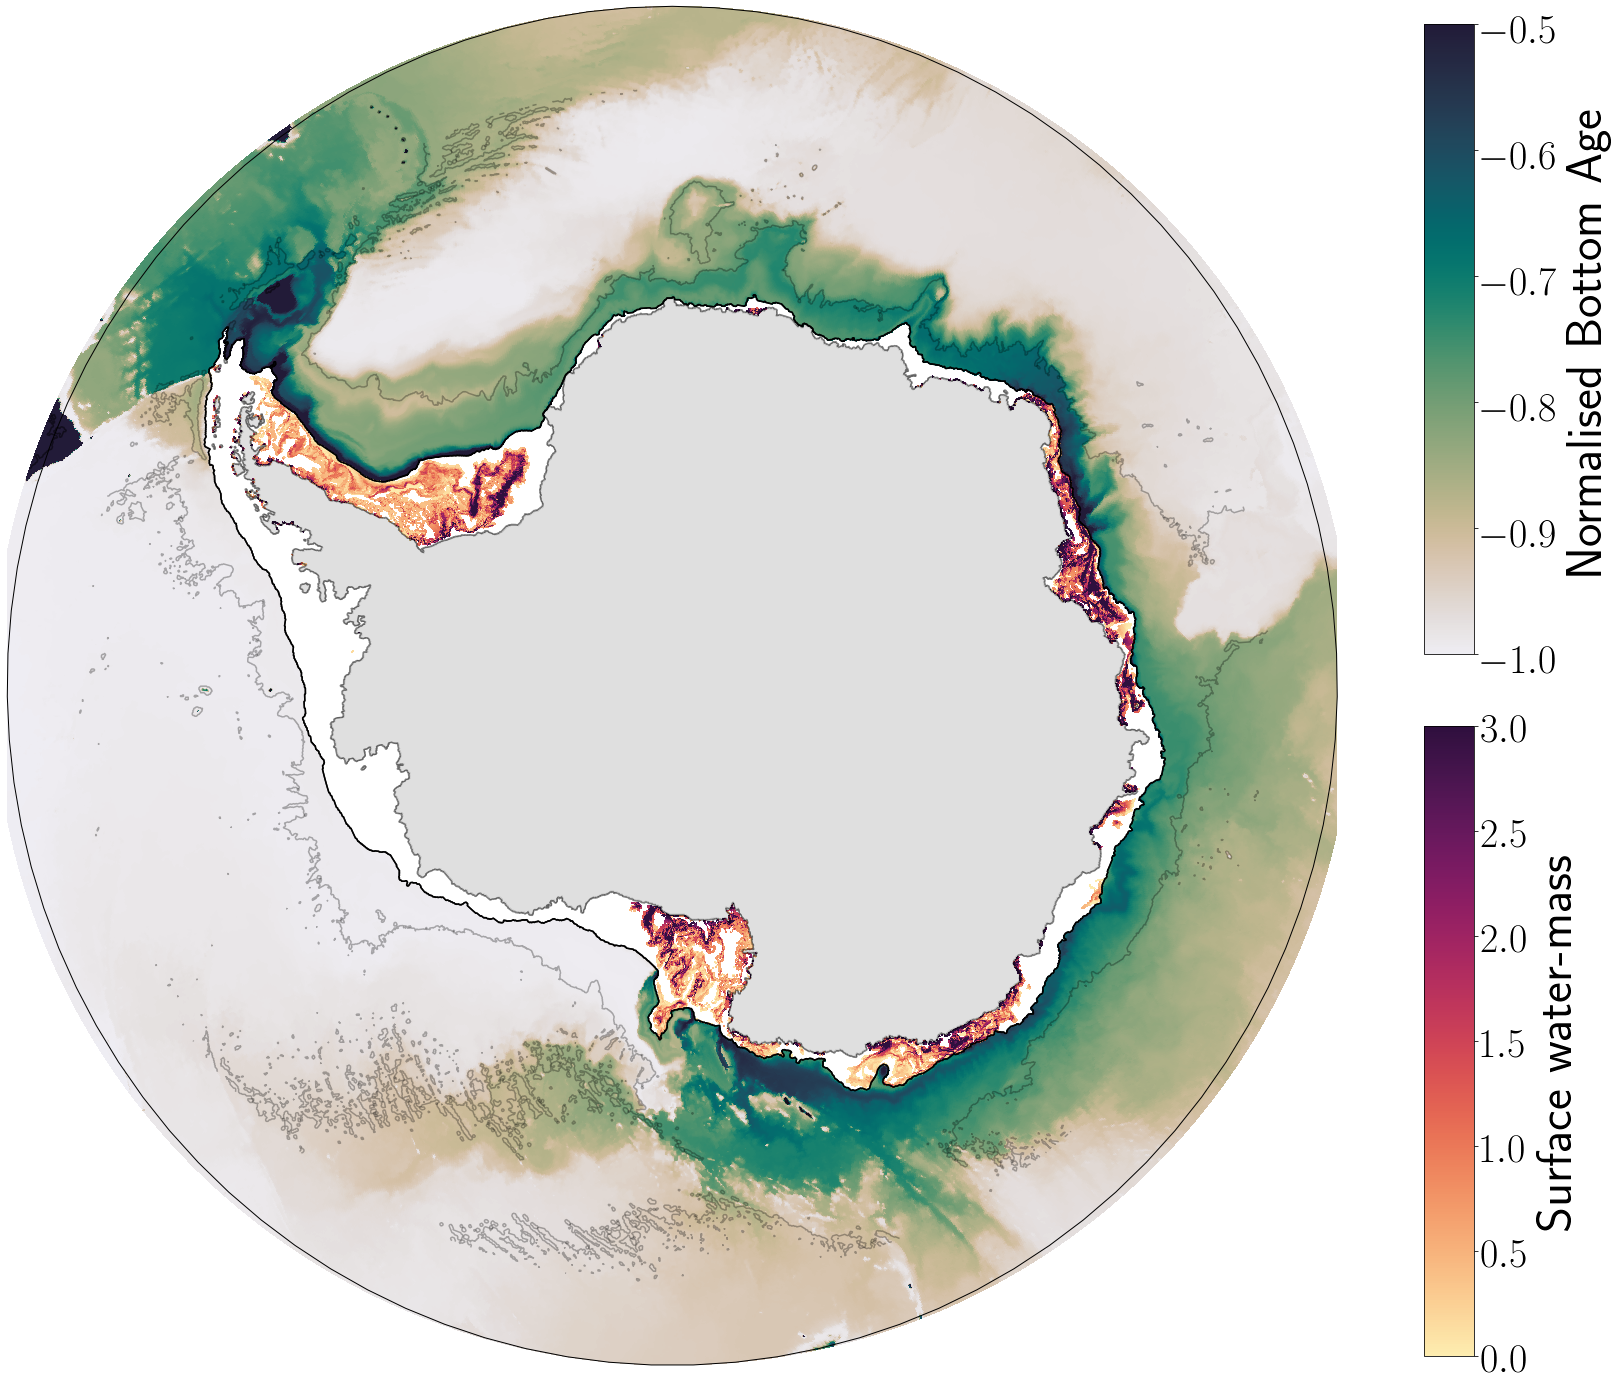

In [45]:
fig  = plt.figure(1, figsize = (25,25))
ax0= plt.subplot(projection=ccrs.SouthPolarStereo())

fill_land(land_mask, ax0, yt_ocean, xt_ocean, fill_colour = 'silver', a = 0.5)
ax0.contour(xt_ocean, yt_ocean,land_mask,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform = ccrs.PlateCarree() )
ax0.contour(shelf_mask.xt_ocean, shelf_mask.yt_ocean,shelf_mask,[0,1], colors = 'k', alpha =0.8, linewidth = 1, transform = ccrs.PlateCarree())

## age difference
norm = col.Normalize(vmin=-1,vmax=-0.5)
plot = ax0.pcolormesh(age_norm_off.xt_ocean,age_norm_off.yt_ocean,-age_norm_off,cmap = cmo.rain, norm = norm,transform = ccrs.PlateCarree())
antarctic_map(ax0, isobath_linewidth = 6, grid = False, north = -55)
ax0.contour(contour_4000m.xt_ocean, contour_4000m.yt_ocean,contour_4000m,[0,1], colors = 'k', linewidth = 1, alpha = 0.3, transform = ccrs.PlateCarree())
## swmt
norm = col.Normalize(vmin=0,vmax=3)
plot_swmt = ax0.pcolormesh(swmt_xt,swmt_yt,net_plot,norm=norm,cmap= cmo.matter,transform=ccrs.PlateCarree())


cax = fig.add_axes([0.93, 0.52, 0.028, 0.35])
cbar=plt.colorbar(plot,cax = cax,orientation='vertical',shrink = 0.5, ticks = [-1,-0.9,-0.8,-0.7,-0.6,-0.5])
cbar.set_label(r'Normalised Bottom Age', fontsize = 50)

cax = fig.add_axes([0.93, 0.13, 0.028, 0.35])
cbar=plt.colorbar(plot_swmt,cax = cax,orientation='vertical',shrink = 0.5, ticks = [0, 0.5,1, 1.5,2,2.5,3])
cbar.set_label(r'Surface water-mass', fontsize = 50)

figurepath = 'Figures/Figure_1_SWMT_Age.png'
fig.savefig(figurepath, dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='png',
            transparent=False, bbox_inches='tight', pad_inches=0.1,
            frameon=None)
plt.show()